# Lab 7: Twitter Makes Us Sentimental

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
December 13th, 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline

print('Numpy version: ', np.__version__)
print('Tensorflow version: ', tf.__version__)

Numpy version:  1.24.3
Tensorflow version:  2.13.0


For this lab, we will be using the text-only [Sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140) from Kaggle. This dataset contains 1,600,000 tweets collected from the Twitter API. Below is an example of some of the rows in the dataset:

In [2]:
# Load the data
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Out of the provided columns, we will only need "sentiment" and "text" to classify sentiment in the tweets. Sentiment is the target variable. IDs, date information and the username of the individual who sent the tweet is irrelevant. The flag column refers to how the data was collected and is also irrelevant. Therefore, we will drop these columns.

Additionally, the dataset has 3 sentiment values:

 - 0: Negative
 - 2: Neutral
 - 4: Positive

We don't particularly find any value in classifying a tweet as neutral, so we will only move forward with positive and negative values of sentiment. Additionally, we will convert all of the 4s for positive sentiment to 1s to format the problem as a more classic binary classification problem.

In [3]:
df = df[['sentiment', 'text']]
df['sentiment'] = df['sentiment'].replace(4, 1)
NUM_CLASSES = 1

Additionally, with sequential networks, 1.6 million records will take a considerably long amount of time to train. Therefore, we will reduce the dataset size to 50,000, with a 50-50 class balance. We can always use more records later if we feel the need to.

In [4]:
# reduce size of dataset to 50,000 with equal number of positive and negative tweets
df_pos = df[df['sentiment'] == 1].sample(25000)
df_neg = df[df['sentiment'] == 0].sample(25000)
df = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)

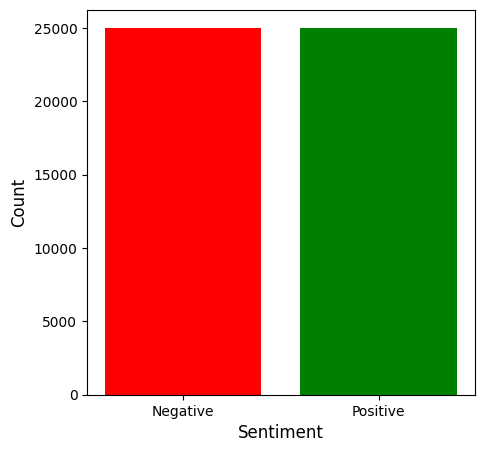

In [5]:
# plot the distribution of positive and negative sentiment

count = df['sentiment'].value_counts()
plt.figure(figsize=(5,5))
plt.bar(count.index, count.values, color=['green', 'red'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(range(len(count.index)), ['Negative', 'Positive'])
plt.show()

### Evaluation Metric

Our evaluation metric of choice for this lab will be classification accuracy. 

Because of the balance we created by sampling postiive and negative tweets evenly, accuracy becomes more relevant because no class is overrpresented or underrepresented. We can evaluate a model with accuracy to see how it correctly classifies both classes. Additionally, there is no real penalty for misclassification. If we were operating with something like medical data, where false negatives would be extremely costly and false positives were less costly but still undesirable, then it would make sense to use something that measures precision and recall, like an FBeta score with a higher beta value. However, given the nature of our data, there is no mission-critical penalty for misclassification. We are simply interested in how well we can identify the sentiment of a tweet.

The goal of sentiment analysis is to correctly classify the sentiment of the records as accurately as possible; the business case is not to avoid misclassification at all costs like it might be with a medical scenario. Therefore, we feel that accuracy is the correct evaluation metric for this lab.

### Preprocessing

Now, we apply several preprocessing steps to each record:

 - Convert text to lowercase.
 - Replace any instances of URLs with a "URL" token.
 - Replace any instance of a user @'ing another user with a "USER" token.
 - Replace any instances of an eomji with its corresponding unicode representation.
 - Replace any contractions with the expanded contraction, i.e. turning "you're" into "you are".
 - Remove any non-alphanumeric characters.

In [6]:
import re
import contractions

def preprocessing(tweet):
    # Convert tweet to lower case
    tweet = tweet.lower()
    
    # Replace URLs with token
    tweet = re.sub(r'http\S+|www\S+|https\S+', 'URL', tweet)
    
    # Replace user handles with token
    tweet = re.sub(r'@\w+', 'USER', tweet)

    # Replace emojis with token (basic example)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('EMOJI', tweet)
    
    # Replace contractions with their expansions
    tweet = contractions.fix(tweet)
    
    # Remove non-alphanumeric characters
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    
    return tweet


In [7]:
%%time
df['processed_text'] = df['text'].apply(preprocessing)

CPU times: total: 688 ms
Wall time: 708 ms


In [8]:
# Print out 10 samples of the original and processed text
for i in range(30,40):
    print('Original text: ', df['text'][i])
    print('Processed text: ', df['processed_text'][i])
    print()

Original text:  Photo: Mica (douchetitty) on the left, me on the right. Our new tats!  http://tumblr.com/x9r21zz5p
Processed text:  photo mica douchetitty on the left me on the right our new tats  URL

Original text:  Its a sunny day but what am i doing.. im inside with my computer  the wonders of technology today ^^
Processed text:  its a sunny day but what am i doing i am inside with my computer  the wonders of technology today 

Original text:  Wiiiiiide awake now. Lunch with friends at 11 
Processed text:  wiiiiiide awake now lunch with friends at 11 

Original text:  @choose2befit enjoy is certainly a relative term when it comes 2 p90x  training 4 an ironman was easier than working out w/ @Tony_Horton
Processed text:  USER enjoy is certainly a relative term when it comes 2 p90x  training 4 an ironman was easier than working out w USER

Original text:  @robs_maid thanks 
Processed text:  USER thanks 

Original text:  Def spent the day in bed. Getting some grub and getting pretty  p

Next, we want to see some words that correlate to positive and negative sentiment just for curiosity's sake, so we will create a couple of word clouds:

In [9]:
data_pos = df[df['sentiment'] == 1]['processed_text'].values
data_neg = df[df['sentiment'] == 0]['processed_text'].values

In [10]:
# create a word cloud for positive and negative tweets
from wordcloud import WordCloud

# Create positive and negative word lists for creating word clouds
data_pos = list(df[df['sentiment'] == 1]['processed_text'])
data_neg = list(df[df['sentiment'] == 0]['processed_text'])

def plot_wordcloud(data, color='black'):
    wordcloud = WordCloud(background_color=color, max_words=1000, width=1600, height=800, random_state=42, collocations=False).generate(" ".join(data))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

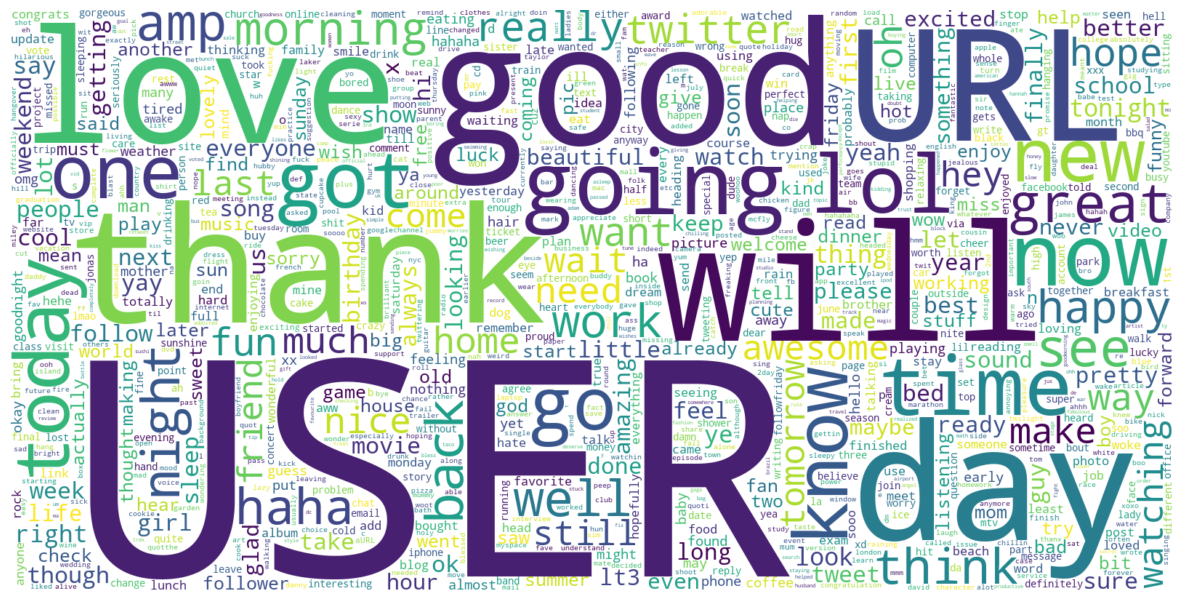

In [11]:
plot_wordcloud(data_pos, 'white')

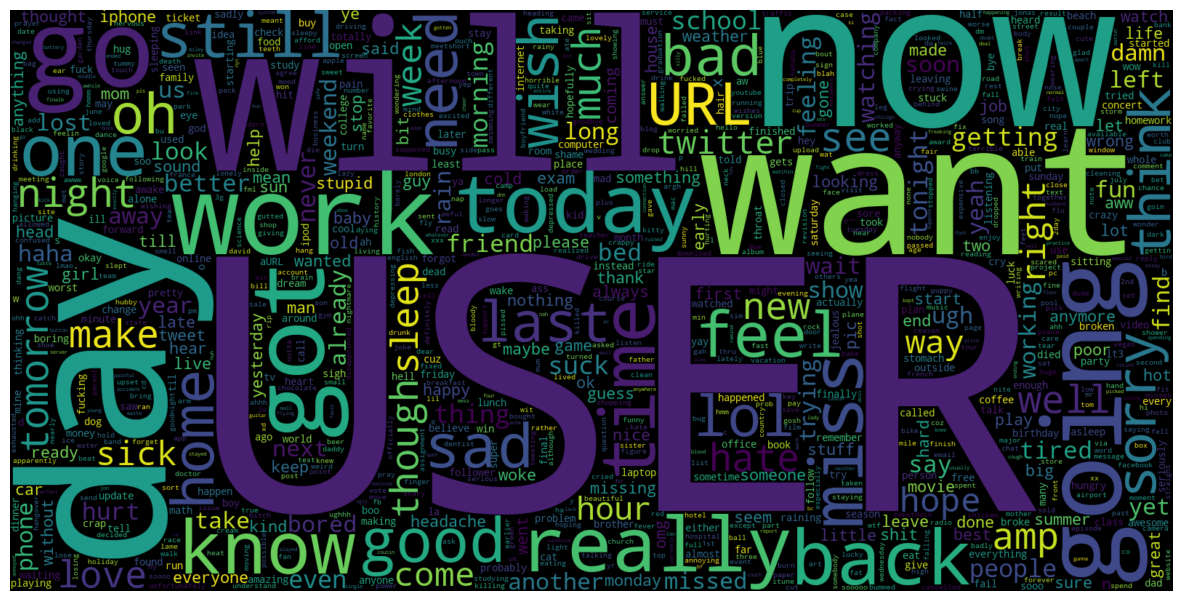

In [12]:
plot_wordcloud(data_neg)

First, obviously people using Twitter to converse with each other means that tweets of any sentiment will contain @'s of other users. Many of the words do make sense with each sentiment; "love," "good", and "thank" definitely belong in the positive word cloud. On the other hand, people complaining about "work", or saying things are "bad" make sense in the negative cloud. However, there is some interesting crossover in words that are probably more neutral, such as "day" - someone could be saying they had a good day or bad day.

Now, we will set up our vocabulary by tokenizing the text and storing the tokens as sequences of integers:

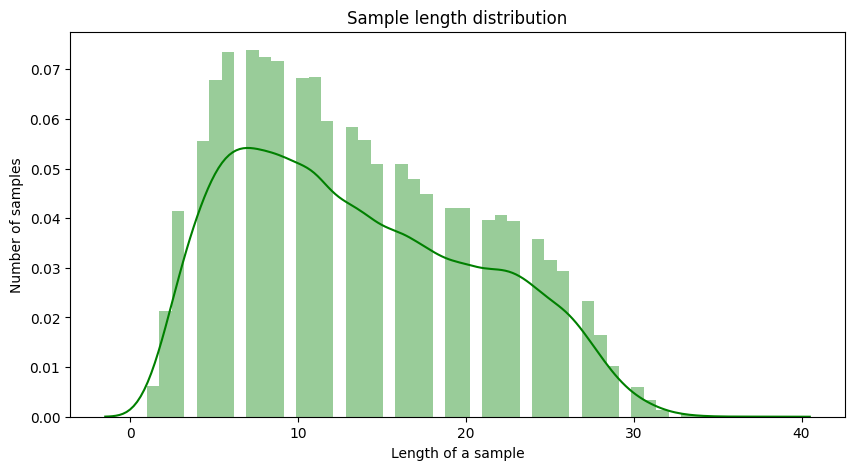

In [13]:
# plot the distribution of tweet lengths
import warnings
warnings.simplefilter('ignore', UserWarning)

plt.figure(figsize=(10, 5))
sns.distplot([len(s.split()) for s in df['processed_text']], color='green')
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [14]:
# find the max length of a tweet
max_len = max([len(s.split()) for s in df['processed_text']])
print('Max length of a tweet: ', max_len, 'tokens.')

Max length of a tweet:  38 tokens.


We chose to set the max word length of a record to 38, because from the distribution above and snippet above, we can see that the longest tweets contain 38 tokens. This means that we will also pad all other sequences to be of length 38.

In [15]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df['processed_text'].values
y = df['sentiment'].values

# Limit the sequence to 38 words
MAX_LEN = max_len
VOCAB_SIZE = 60000

# Tokenize the text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', lower=False)
tokenizer.fit_on_texts(X)

# Save as sequences with integers instead of words
sequences = tokenizer.texts_to_sequences(X)

# Set vocab size to number of words if number of words < 60,000
word_index = tokenizer.word_index
VOCAB_SIZE = (len(word_index) + 1) if VOCAB_SIZE > (len(word_index) + 1) else VOCAB_SIZE 
top_words = min((len(word_index) + 1, VOCAB_SIZE)) # Keep all of the top words
print('Found %s unique tokens. Distilled to %s.' % (len(word_index) + 1, top_words))

# Pad the sequences to be 36 words long
X = pad_sequences(sequences, maxlen=MAX_LEN)
y_ohe = keras.utils.to_categorical(y, 2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(VOCAB_SIZE)

Found 42189 unique tokens. Distilled to 42189.
Shape of data tensor: (50000, 38)
Shape of label tensor: (50000, 2)
42189
CPU times: total: 1.41 s
Wall time: 1.48 s


### Splitting the Data

Given the size of our dataset, we will opt for a simple train / test split of 80% / 20%. We feel comfortable training a model on 40,000 instances and then testing the model with 10,000 instances. If our dataset was smaller, say only 5,000 - 10,000 instances total, then we might want to perform some additional validation such as k-fold cross validation. However, for a dataset of this size, we believe we can train it as-is.

We will not perform any sort of stratified selection or synthetic sampling on the train / test split as the data we pulled already has an even class balance. Additionally, in a real-world scenario, it is highly unlikely that there would be a perfect 50% / 50% class balance on raw data taken from the internet, so we want our model to mirror a realistic implementation when we test it. 

X_train shape:  (40000, 38) Label shape:  (40000, 2)


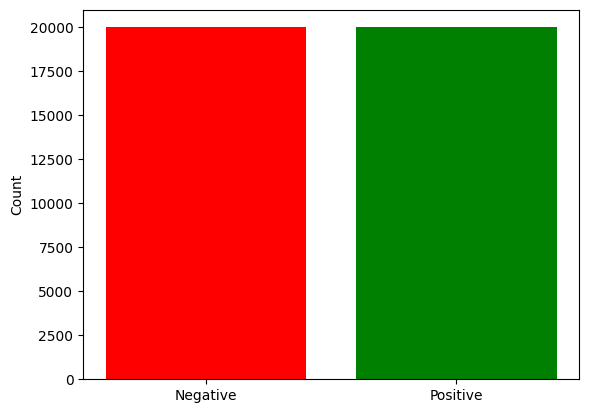

In [16]:
from sklearn.model_selection import train_test_split

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,test_size=0.2, random_state=42, stratify=y_ohe)

# print out some stats of the data
print('X_train shape: ', X_train.shape, 'Label shape: ', y_train.shape)
count = np.sum(y_train, axis=0)
plt.bar(range(2), count, color=['red', 'green'])
plt.xticks(range(2), ['Negative', 'Positive'])
plt.ylabel('Count')
plt.show()

### Embedding

To create our first embedding layer, we use [GloVe's pre-trained word vectors](https://nlp.stanford.edu/projects/glove/). There is actually a dataset of word vectors specific to Twitter, so we will opt to use that instead of the Wikipedia or Common Crawl data. Hopefully using the Twitter vectors will align more closely with the words present in our dataset.

In [17]:
%%time
EMBEDDING_SIZE = 100

embeddings_index = {}
f = open('Embeddings/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 1193514 word vectors.
Embedding shape:  (42189, 100)
Total words found:  27898
Percentage:  66.12624143734148
CPU times: total: 26.5 s
Wall time: 26.5 s


In [18]:
from tensorflow.keras.layers import Embedding

# save the embedding layer as a variable
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

### CNN #1

We opted to create convolutional neural networks as our first choice of model for this lab. Our first architecture is a simple CNN, with the embedding layer first and a Conv1D layer, then followed by two blocks of MaxPooling1D - Dropout - Conv1D, then a GlobalAveragePooling1D layer, a flatten layer, a dropout, and finally 2 dense layers to get to our predictions. 

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)

preds = Dense(2, activation='softmax')(x)

cnn = Model(sequence_input, preds)

cnn.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(cnn.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 embedding (Embedding)       (None, 38, 100)           4218900   
                                                                 
 conv1d (Conv1D)             (None, 34, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 17, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 17, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 128)           82048     
                                                             

In [20]:
history_cnn = []
tmp = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
history_cnn.append(tmp)

Epoch 1/10
313/313 [==============================] - 7s 18ms/step - loss: 0.6010 - accuracy: 0.6717 - val_loss: 0.5443 - val_accuracy: 0.7263
Epoch 2/10
313/313 [==============================] - 6s 18ms/step - loss: 0.5341 - accuracy: 0.7353 - val_loss: 0.5385 - val_accuracy: 0.7314
Epoch 3/10
313/313 [==============================] - 6s 18ms/step - loss: 0.5054 - accuracy: 0.7558 - val_loss: 0.5378 - val_accuracy: 0.7386
Epoch 4/10
313/313 [==============================] - 6s 18ms/step - loss: 0.4769 - accuracy: 0.7724 - val_loss: 0.5337 - val_accuracy: 0.7379
Epoch 5/10
313/313 [==============================] - 6s 18ms/step - loss: 0.4423 - accuracy: 0.7940 - val_loss: 0.5704 - val_accuracy: 0.7218
Epoch 6/10
313/313 [==============================] - 5s 17ms/step - loss: 0.4082 - accuracy: 0.8125 - val_loss: 0.5711 - val_accuracy: 0.7244
Epoch 7/10
313/313 [==============================] - 6s 18ms/step - loss: 0.3852 - accuracy: 0.8242 - val_loss: 0.5733 - val_accuracy: 0.7252

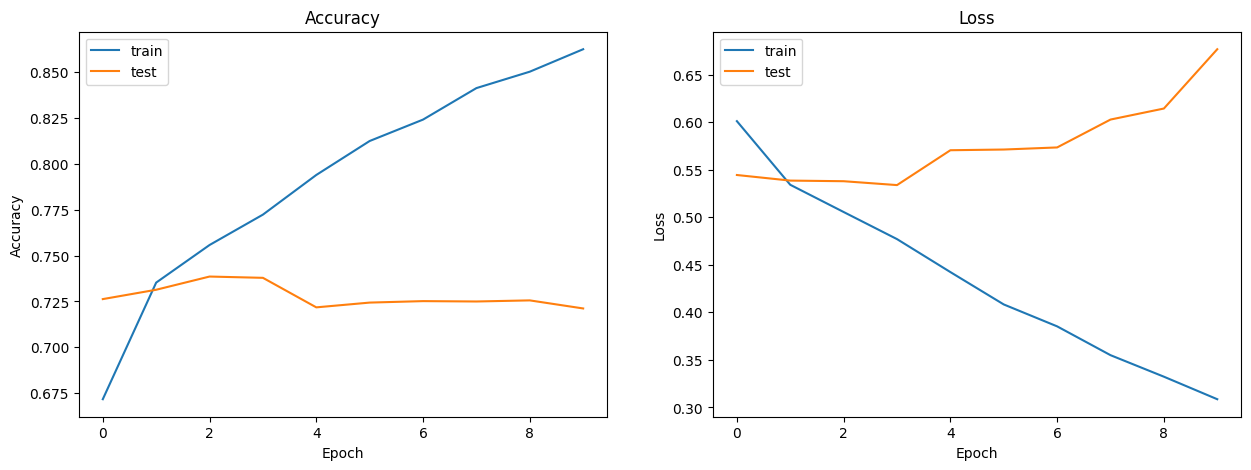

In [21]:
# plot the accuracy and loss of the model

# combine the history from training together
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_cnn])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We noticed a consistent phenomenon when training our CNNs. Whenever we went for more than a few epochs, the CNN would always start overfitting the data, with the testing loss only ever increasing despite good performance on the train data. Therefore, although we could run for more epochs, we will leave the CNN at 10 epochs of training to avoid overfitting too severely. However, even with this weird behavior, getting around 73% accuracy on the first model isn't too shabby.

### Transformer #1

Our next model is our first transformer. This transformer's architecture is taken from the in-class notebook, 13a Sequence Basics (experimental). First, we have an input layer and a GloveTokenAndPositionEmbeddingLayer, which is responsible for tokenizing the input sequences and adding the positional embeddings. Then, we have a part of the core transformer architecture, the TransformerBlock. Those two initial layers are the only new things. After that, we have layers for GlobalAveragePooling1D, 2 dropout layers, and 2 dense layers, all of which we have used before with CNNs.

In [22]:
# From notebook 13a, Sequence Basics [experimental]

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(len(word_index) + 1,
                                   EMBEDDING_SIZE,
                                   weights=[embedding_matrix],
                                   input_length=MAX_LEN,
                                   trainable=False)
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_LEN,
                                 EMBEDDING_SIZE,
                                 input_length=MAX_LEN,
                                 trainable=True)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [23]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
temp = GloveTokenAndPositionEmbedding()(inputs)
temp = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(temp)

temp = GlobalAveragePooling1D()(temp)
temp = Dropout(0.2)(temp)
temp = Dense(64, activation='relu')(temp)
temp = Dropout(0.2)(temp)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(temp)

model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 38)]              0         
                                                                 
 glove_token_and_position_e  (None, 38, 100)           4222700   
 mbedding (GloveTokenAndPos                                      
 itionEmbedding)                                                 
                                                                 
 transformer_block (Transfo  (None, 38, 100)           168232    
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d_1  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 100)               0   

In [24]:
model_xformer.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])


history_xformer = []
tmp = model_xformer.fit(
    X_train, y_train, batch_size=64, epochs=10, 
    validation_data=(X_test, y_test)
)
history_xformer.append(tmp)

Epoch 1/10
625/625 [==============================] - 29s 44ms/step - loss: 0.5185 - accuracy: 0.7438 - val_loss: 0.4772 - val_accuracy: 0.7672
Epoch 2/10
625/625 [==============================] - 27s 43ms/step - loss: 0.4804 - accuracy: 0.7737 - val_loss: 0.4645 - val_accuracy: 0.7754
Epoch 3/10
625/625 [==============================] - 27s 43ms/step - loss: 0.4691 - accuracy: 0.7782 - val_loss: 0.4630 - val_accuracy: 0.7794
Epoch 4/10
625/625 [==============================] - 27s 43ms/step - loss: 0.4605 - accuracy: 0.7828 - val_loss: 0.4932 - val_accuracy: 0.7782
Epoch 5/10
625/625 [==============================] - 27s 44ms/step - loss: 0.4547 - accuracy: 0.7886 - val_loss: 0.4606 - val_accuracy: 0.7774
Epoch 6/10
625/625 [==============================] - 27s 43ms/step - loss: 0.4494 - accuracy: 0.7886 - val_loss: 0.4656 - val_accuracy: 0.7794
Epoch 7/10
625/625 [==============================] - 27s 44ms/step - loss: 0.4449 - accuracy: 0.7911 - val_loss: 0.4643 - val_accuracy:

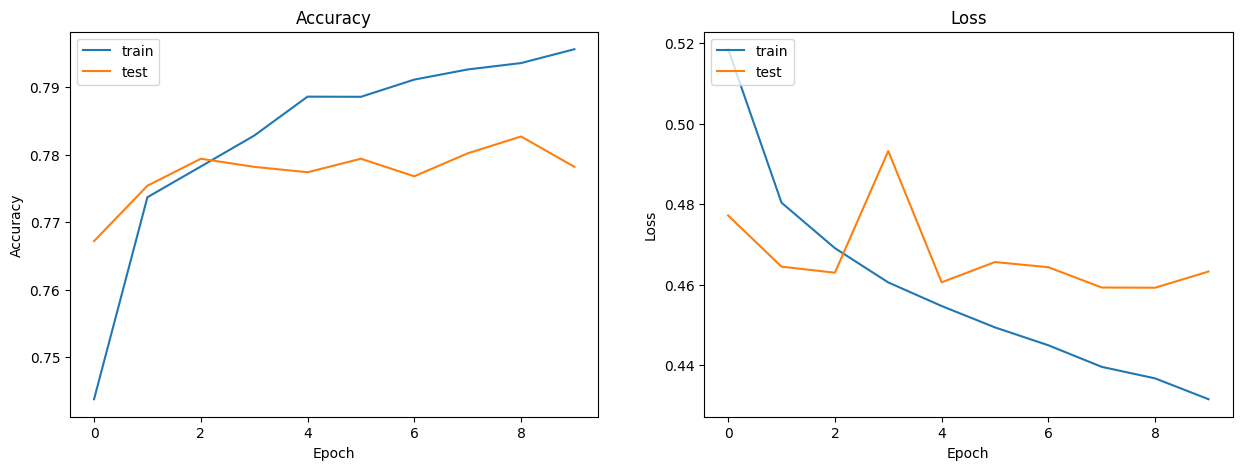

In [25]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Similarly with the CNN, the transformers start to overfit this dataset rather quickly. We tested with up to 25 epochs, but the loss was always increasing, resulting in lower accuracies. As such, even though the transformer does not appear to be fully converged, we will leave it at 10 epochs.

The transformer performs noticeably better than the CNN right off the bat. The difference isn't too big, but getting around 78% testing accuracy is a considerable increase.

Now, for our second CNN and second transformer, the parameter we change will be the embedding. We will still use GloVe's Twitter embeddings, but this time we are using the 200-dimensional vectors instead of the 100-dimensional vectors. We wanted to experiment with the embedding as a hyperparameter, since this is one of the novel topics for this lab.

In [26]:
%%time
EMBEDDING_SIZE = 200

embeddings_index = {}
f = open('Embeddings/glove.twitter.27B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 1193514 word vectors.
Embedding shape:  (42189, 200)
Total words found:  27898
Percentage:  66.12624143734148
CPU times: total: 50 s
Wall time: 50.2 s


In [27]:
# save the embedding layer as a variable
embedding_layer_200d = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

### CNN #2

CNN 2's only difference from CNN 1 is its usage of the 200-dimensional embedding layer instead of the 100-dimensional embedding layer.

In [28]:
sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer_200d(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)

preds = Dense(2, activation='softmax')(x)

cnn2 = Model(sequence_input, preds)

cnn2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(cnn2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 38)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 38, 200)           8437800   
                                                                 
 conv1d_3 (Conv1D)           (None, 34, 128)           128128    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 17, 128)           0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 17, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 13, 128)           82048     
                                                           

In [29]:
cnn2_history = []
tmp = cnn2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
cnn2_history.append(tmp)

Epoch 1/10
313/313 [==============================] - 8s 23ms/step - loss: 0.5850 - accuracy: 0.6883 - val_loss: 0.5353 - val_accuracy: 0.7347
Epoch 2/10
313/313 [==============================] - 7s 23ms/step - loss: 0.5176 - accuracy: 0.7448 - val_loss: 0.5287 - val_accuracy: 0.7362
Epoch 3/10
313/313 [==============================] - 7s 23ms/step - loss: 0.4835 - accuracy: 0.7667 - val_loss: 0.5285 - val_accuracy: 0.7421
Epoch 4/10
313/313 [==============================] - 7s 22ms/step - loss: 0.4403 - accuracy: 0.7940 - val_loss: 0.5438 - val_accuracy: 0.7353
Epoch 5/10
313/313 [==============================] - 7s 23ms/step - loss: 0.3970 - accuracy: 0.8185 - val_loss: 0.5913 - val_accuracy: 0.7315
Epoch 6/10
313/313 [==============================] - 8s 25ms/step - loss: 0.3526 - accuracy: 0.8425 - val_loss: 0.6210 - val_accuracy: 0.7226
Epoch 7/10
313/313 [==============================] - 7s 23ms/step - loss: 0.3176 - accuracy: 0.8593 - val_loss: 0.6049 - val_accuracy: 0.7304

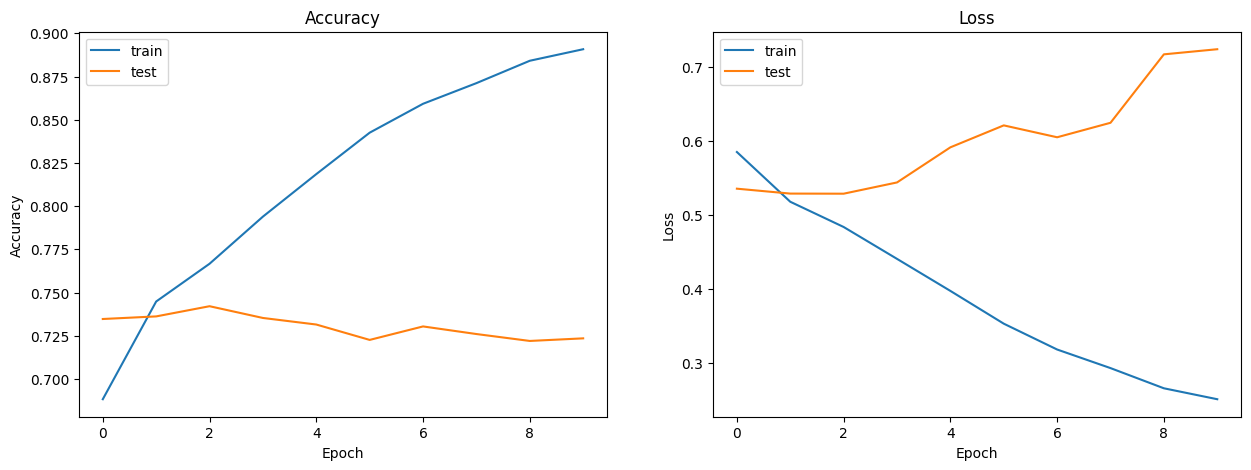

In [31]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in cnn2_history])
    
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Again, as we saw with the first couple of models, our model converges very quickly and begins to only lose accuracy the longer we run it.

The two CNNs seem to perform very closely to each other, with both of their validation accuracies peaking in the mid-70s. This shows that changing the embedding dimensions doesn't really change much, at least for the CNN architectures.

### Transformer #2

Just like with CNN 1 and CNN 2, the only change with this transformer is the use of the 200D embeddings instead of the 100D embeddings.

In [32]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
temp = GloveTokenAndPositionEmbedding()(inputs)
temp = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(temp)

temp = GlobalAveragePooling1D()(temp)
temp = Dropout(0.2)(temp)
temp = Dense(64, activation='relu')(temp)
temp = Dropout(0.2)(temp)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(temp)

model_xformer2 = Model(inputs=inputs, outputs=outputs)
print(model_xformer2.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 38)]              0         
                                                                 
 glove_token_and_position_e  (None, 38, 200)           8445400   
 mbedding_1 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_1 (Trans  (None, 38, 200)           656432    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_3  (None, 200)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_12 (Dropout)        (None, 200)               0   

In [33]:
model_xformer2.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

history_xformer2 = []
tmp = model_xformer2.fit(
    X_train, y_train, batch_size=64, epochs=10, 
    validation_data=(X_test, y_test)
)
history_xformer2.append(tmp)

Epoch 1/10
625/625 [==============================] - 64s 100ms/step - loss: 0.5037 - accuracy: 0.7572 - val_loss: 0.4690 - val_accuracy: 0.7750
Epoch 2/10
625/625 [==============================] - 62s 99ms/step - loss: 0.4659 - accuracy: 0.7825 - val_loss: 0.4693 - val_accuracy: 0.7761
Epoch 3/10
625/625 [==============================] - 64s 103ms/step - loss: 0.4542 - accuracy: 0.7873 - val_loss: 0.4655 - val_accuracy: 0.7778
Epoch 4/10
625/625 [==============================] - 63s 101ms/step - loss: 0.4448 - accuracy: 0.7931 - val_loss: 0.4530 - val_accuracy: 0.7850
Epoch 5/10
625/625 [==============================] - 64s 103ms/step - loss: 0.4373 - accuracy: 0.7979 - val_loss: 0.4661 - val_accuracy: 0.7828
Epoch 6/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4302 - accuracy: 0.8006 - val_loss: 0.4580 - val_accuracy: 0.7851
Epoch 7/10
625/625 [==============================] - 62s 100ms/step - loss: 0.4246 - accuracy: 0.8010 - val_loss: 0.4675 - val_acc

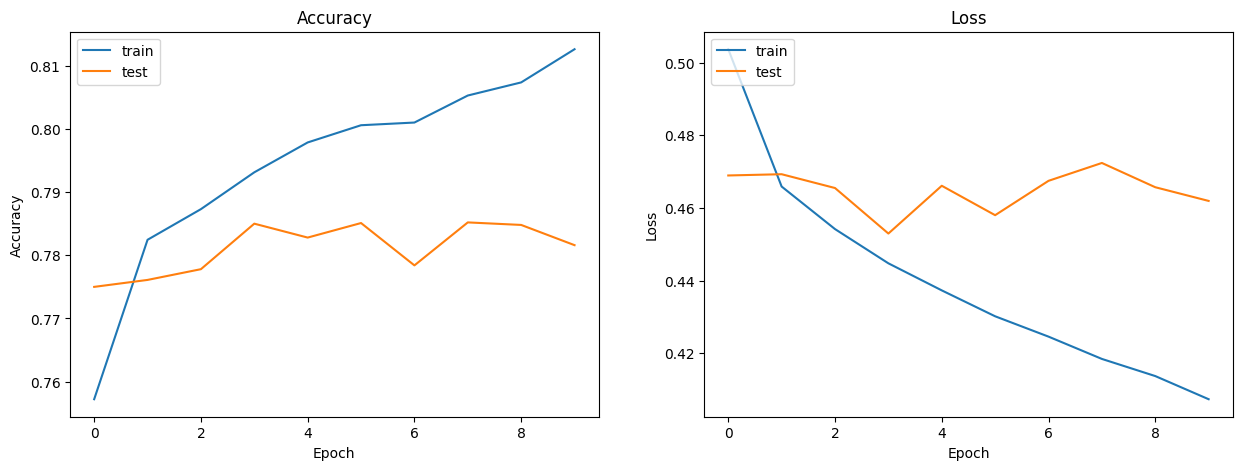

In [36]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer2])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This transformer does seem to perform very similarly to the first transformer. The accuracies again peak at around the same values, although this one may be very slightly better than the other. We will perform more detailed comparisons later to determine if the different embedding sizes make an actual statistical difference, but it seems it doesn't really change validation accuracy.

### Transformer #3

For our third transformer, we added another TransformerBlock layer to Transformer 2's architecture (so we are still using the 200D embeddings). Adding this second TransformerBlock serves the purpose of adding another multi-headed self attention layer, so now the outputs of the first attention layer are used as inputs for the second attention layer. The rest of the model is the same as Transformer 2.

In [37]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer3 = Model(inputs=inputs, outputs=outputs)
model_xformer3.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
print(model_xformer3.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 38)]              0         
                                                                 
 glove_token_and_position_e  (None, 38, 200)           8445400   
 mbedding_2 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_2 (Trans  (None, 38, 200)           656432    
 formerBlock)                                                    
                                                                 
 transformer_block_3 (Trans  (None, 38, 200)           656432    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_4  (None, 200)               0   

In [38]:
history_xformer3 = []
tmp = model_xformer3.fit(
    X_train, y_train, batch_size=64, epochs=10, 
    validation_data=(X_test, y_test)
)
history_xformer3.append(tmp)

Epoch 1/10
625/625 [==============================] - 120s 188ms/step - loss: 0.5122 - accuracy: 0.7521 - val_loss: 0.4685 - val_accuracy: 0.7837
Epoch 2/10
625/625 [==============================] - 118s 189ms/step - loss: 0.4762 - accuracy: 0.7757 - val_loss: 0.4612 - val_accuracy: 0.7800
Epoch 3/10
625/625 [==============================] - 118s 189ms/step - loss: 0.4658 - accuracy: 0.7825 - val_loss: 0.4582 - val_accuracy: 0.7818
Epoch 4/10
625/625 [==============================] - 118s 189ms/step - loss: 0.4607 - accuracy: 0.7855 - val_loss: 0.4697 - val_accuracy: 0.7808
Epoch 5/10
625/625 [==============================] - 118s 189ms/step - loss: 0.4533 - accuracy: 0.7898 - val_loss: 0.4672 - val_accuracy: 0.7763
Epoch 6/10
625/625 [==============================] - 119s 190ms/step - loss: 0.4474 - accuracy: 0.7938 - val_loss: 0.4749 - val_accuracy: 0.7781
Epoch 7/10
625/625 [==============================] - 118s 190ms/step - loss: 0.4432 - accuracy: 0.7955 - val_loss: 0.4698 -

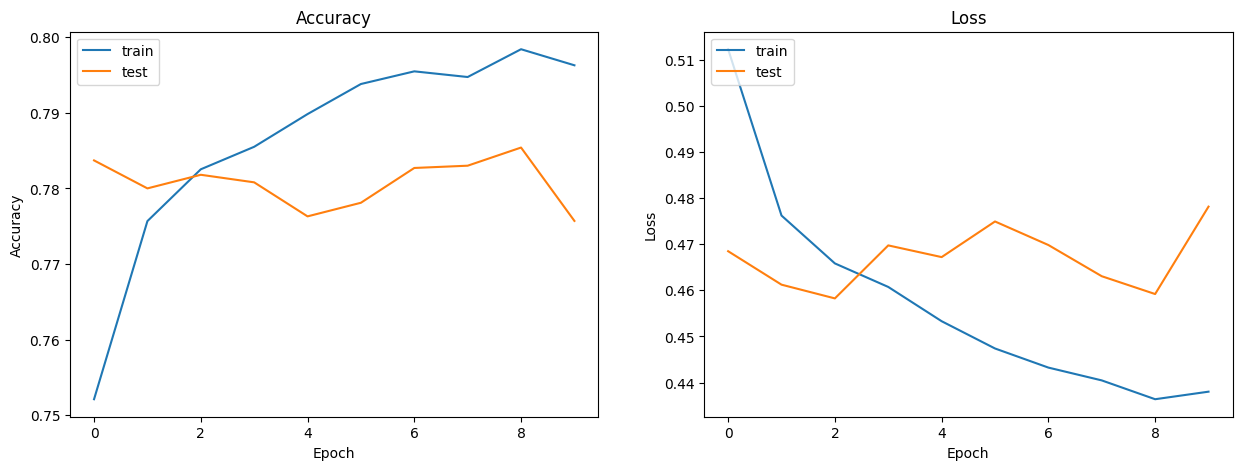

In [39]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer3])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Again, the training converges quickly but we are at risk of overfitting severely if we keep letting our training run, so we cut off at 10 epochs.

For the third transformer, the accuracy is in the same ballpark as the other two transformers in the upper 70s. We still aren't quite able to break that 80% mark.

Now that we have two trained CNNs and three trained transformers, we will compare them to each other to try and determine which is the best performing. First, we create a function to visualize the accuracies of all the models together, and then we create a function to perform a paired t-test to determine if there are statistical differences between the models with 95% confidence:

In [40]:
# Helper function to plot model accuracies
def plot_history(model_histories, model_names):
    plt.figure(figsize=(10, 6))
    
    for i, history in enumerate(model_histories):
        epochs = len(history.history['val_accuracy'])
        plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label=model_names[i], marker='o')
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()    
    plt.show()


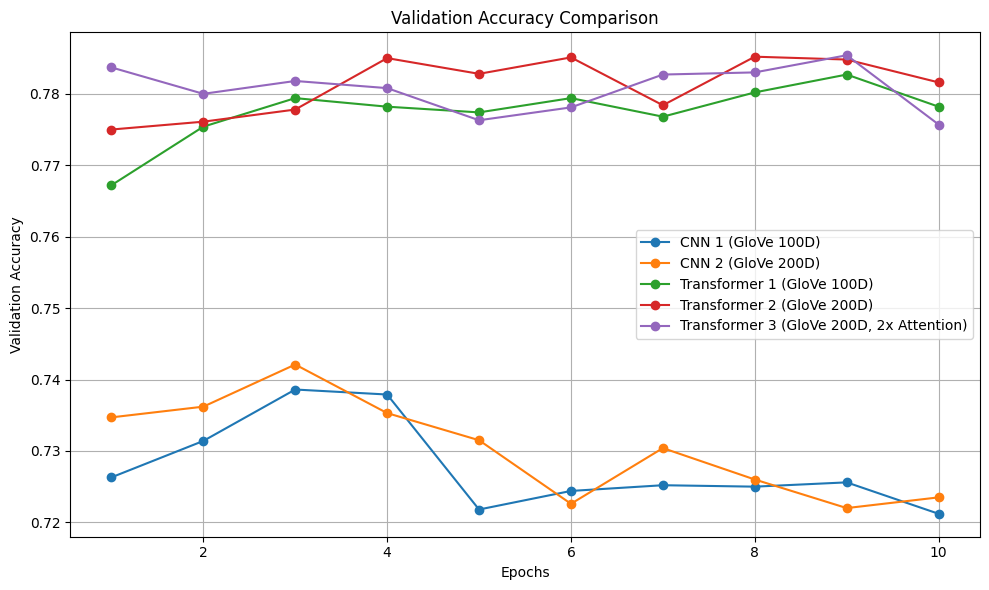

In [43]:
model_histories = [history_cnn[0], cnn2_history[0], history_xformer[0], history_xformer2[0], history_xformer3[0]]
model_names = ['CNN 1 (GloVe 100D)', 'CNN 2 (GloVe 200D)', 'Transformer 1 (GloVe 100D)', 'Transformer 2 (GloVe 200D)', 'Transformer 3 (GloVe 200D, 2x Attention)']
plot_history(model_histories, model_names)

From the accuracy plot, we see a few interesting takeaways. First, there are clearly two "clusters" of accuracies: the CNNs and the transformers. The transformers outperform the CNNs in validation accuracy by a few percentage points. This shows that the transformers are overall more accurate in their sentiment classification, so we would want to use a transformer moving forward instead of a CNN. 

However, within the clusters themselves, the results are very close. In the CNNs, we can see that we maybe should have cut off training even earlier; the accuracy dips noticeably after about 4 epochs, and never really recovers to where it previously was. But the overall performance of CNN 1 vs CNN 2 is extremely close. Similarly, the accuracy results for the transformers are very close to each other as well, but the models do not seem to overfit as severely. There is still some spikiness in thhe accuracy, but it still does get higher sometimes in the later epochs. Transformers 2 and 3 do seem to overall be slightly higher than Transformer 1 most of the time.

In [65]:
# Finding the maximum validation accuracy value among all models
print("Highest value in CNN 1:", max(history_cnn[0].history['val_accuracy']))
print("Highest value in CNN 2:", max(cnn2_history[0].history['val_accuracy']))
print("Highest value in Transformer 1:", max(history_xformer[0].history['val_accuracy']))
print("Highest value in Transformer 2:", max(history_xformer2[0].history['val_accuracy']))
print("Highest value in Transformer 3:", max(history_xformer3[0].history['val_accuracy']))

Highest value in CNN 1: 0.7386000156402588
Highest value in CNN 2: 0.7421000003814697
Highest value in Transformer 1: 0.7827000021934509
Highest value in Transformer 2: 0.7851999998092651
Highest value in Transformer 3: 0.7853999733924866


Overall, the highest classification accuracy we attained came from Transformer 3, with 78.54% accuracy, so Transformer 3 seems to be our best model. However, given how close transformers 2 and 3 are, it could likely be either of these on another split of the data.

Now, let's perform the statistical tests to see if our models are meaningfully different:

In [47]:
# Helper function to perform a paired t-test statistical comparison between the evaluation metric of two models
from scipy import stats

def paired_t_test(model1_history, model2_history):
    
    # Perform a paired t-test
    t_statistic, p_value = stats.ttest_rel(model1_history.history['val_accuracy'], model2_history.history['val_accuracy'])
    
    # Print the results
    print(f"Paired t-test results:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Check for statistical significance with alpha = 0.05, denoting a 95% confidence level
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between model 1 and model 2.")
    else:
        print("Fail to reject the null hypothesis: No significant difference found between model 1 and model 2.")


In [48]:
# Compare CNN 1 and CNN 2
paired_t_test(history_cnn[0], cnn2_history[0])

Paired t-test results:
T-statistic: -1.8819958995816455
P-value: 0.09251113111408774
Fail to reject the null hypothesis: No significant difference found between model 1 and model 2.


In [49]:
# Compare CNN 1 and Transfomer 1
paired_t_test(history_cnn[0], history_xformer[0])

Paired t-test results:
T-statistic: -21.49125504074032
P-value: 4.810868487225921e-09
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


In [50]:
# Compare CNN 2 and Transformer 2
paired_t_test(cnn2_history[0], history_xformer2[0])

Paired t-test results:
T-statistic: -16.312745910256517
P-value: 5.4327349021438804e-08
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


In [51]:
# Compare Transformer 1 and Transformer 2
paired_t_test(history_xformer[0], history_xformer2[0])

Paired t-test results:
T-statistic: -3.934837704867673
P-value: 0.003432743728282547
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


In [52]:
# Compare Transformer 2 and Transformer 3
paired_t_test(history_xformer2[0], history_xformer3[0])

Paired t-test results:
T-statistic: 0.24715271961450508
P-value: 0.8103357410537336
Fail to reject the null hypothesis: No significant difference found between model 1 and model 2.


We also find a few interesting insights from the statistical comparisons of the models. First, CNN 1 and CNN 2 have no significant difference. Given the similar performance between the CNNs, we are not shocked by this result. Both CNN 1 and Transformer 1, and CNN 2 and Transformer 2, have significant differences. This makes sense given these are two entirely different types of models - it would be strange for them to have no statistical difference. Transformer 1 and Transformer 2 DO have a statistical difference, but Transformer 2 and transformer 3 do NOT. This is the most interesting takeaway, because it shows us what actually changed our transformer models. We would have thought that adding a second layer of self attention to the model would change it more significantly than changing the embedding dimensionality. However, it was going from 100D --> 200D in transformers 1 and 2 that gave us a statistical difference between the models. This observation also reinforces the idea we had earlier that transformers 2 and 3 are likely interchangeable as our best model.

### Exceptional Work: ConceptNet Numberbatch Embeddings

For the exceptional work, we are re-using our Transformer 3 architecture, but this time we are using the [ConceptNet Numberbatch](https://github.com/commonsense/conceptnet-numberbatch) word embeddings instead of GloVe. We are using the English-only version of the Numberbatch embeddings. We want to compare this embedding's performance with the GloVe-embedded Transformer 3.

In [53]:
# %%time
EMBEDDING_SIZE = None
conceptnet_embedding_index = {}
with open('Embeddings/numberbatch-en-19.08.txt', encoding='utf-8') as f:
    first_line = f.readline().split()
    EMBEDDING_SIZE = int(first_line[1])

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        conceptnet_embedding_index[word] = coefs

print('Found %s word vectors.' % len(conceptnet_embedding_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = conceptnet_embedding_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 516782 word vectors.
Embedding shape:  (42189, 300)
Total words found:  22559
Percentage:  53.47128398397687


In [54]:
embedding_layer_conceptnet = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

In [55]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer_conceptnet = Model(inputs=inputs, outputs=outputs)
model_xformer_conceptnet.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
print(model_xformer_conceptnet.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 38)]              0         
                                                                 
 glove_token_and_position_e  (None, 38, 300)           12668100  
 mbedding_3 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_4 (Trans  (None, 38, 300)           1464632   
 formerBlock)                                                    
                                                                 
 transformer_block_5 (Trans  (None, 38, 300)           1464632   
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_5  (None, 300)               0   

In [56]:
history_xformer_conceptnet = []
tmp = model_xformer_conceptnet.fit(
    X_train, y_train, batch_size=64, epochs=10, 
    validation_data=(X_test, y_test)
)
history_xformer_conceptnet.append(tmp)

Epoch 1/10
625/625 [==============================] - 199s 315ms/step - loss: 0.5424 - accuracy: 0.7328 - val_loss: 0.4855 - val_accuracy: 0.7648
Epoch 2/10
625/625 [==============================] - 195s 312ms/step - loss: 0.4991 - accuracy: 0.7663 - val_loss: 0.4819 - val_accuracy: 0.7698
Epoch 3/10
625/625 [==============================] - 197s 315ms/step - loss: 0.4872 - accuracy: 0.7711 - val_loss: 0.4879 - val_accuracy: 0.7653
Epoch 4/10
625/625 [==============================] - 199s 318ms/step - loss: 0.4792 - accuracy: 0.7760 - val_loss: 0.4782 - val_accuracy: 0.7724
Epoch 5/10
625/625 [==============================] - 197s 315ms/step - loss: 0.4753 - accuracy: 0.7771 - val_loss: 0.4734 - val_accuracy: 0.7764
Epoch 6/10
625/625 [==============================] - 199s 318ms/step - loss: 0.4741 - accuracy: 0.7767 - val_loss: 0.4684 - val_accuracy: 0.7775
Epoch 7/10
625/625 [==============================] - 192s 308ms/step - loss: 0.4760 - accuracy: 0.7753 - val_loss: 0.4708 -

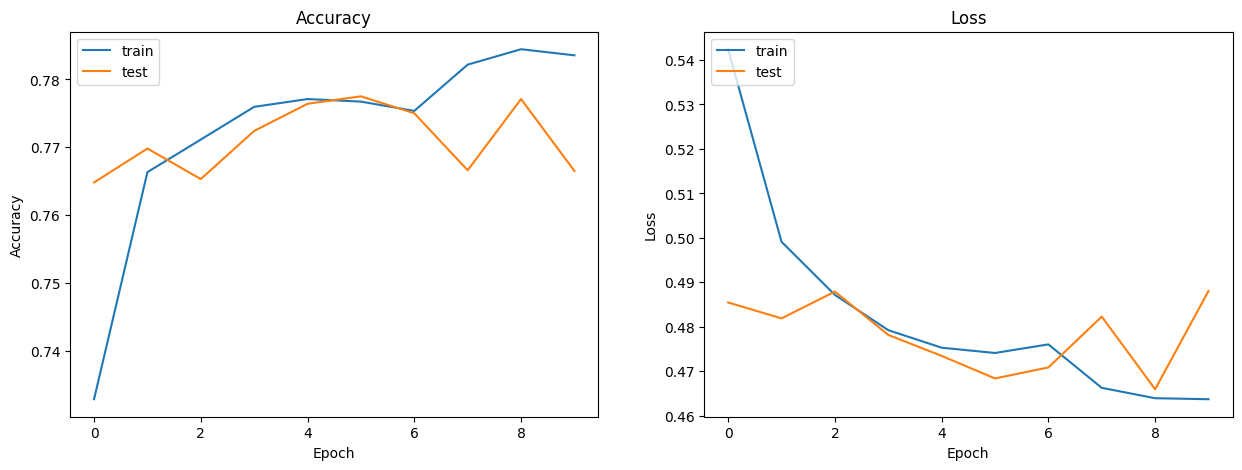

In [66]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer_conceptnet])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Again, this training might not be entirely converged, but it is just about there and we don't want to run into the same overfitting issue we saw with all the other models. But the accuracy seems quite comparable to Transformer 3 right off the bat. It should also be noted that the ConceptNet embeddings take almost twice as long to complete each epoch than the GloVe embeddings, which aren't particularly fast either. So there is a significant time penalty to using ConceptNet embeddings.

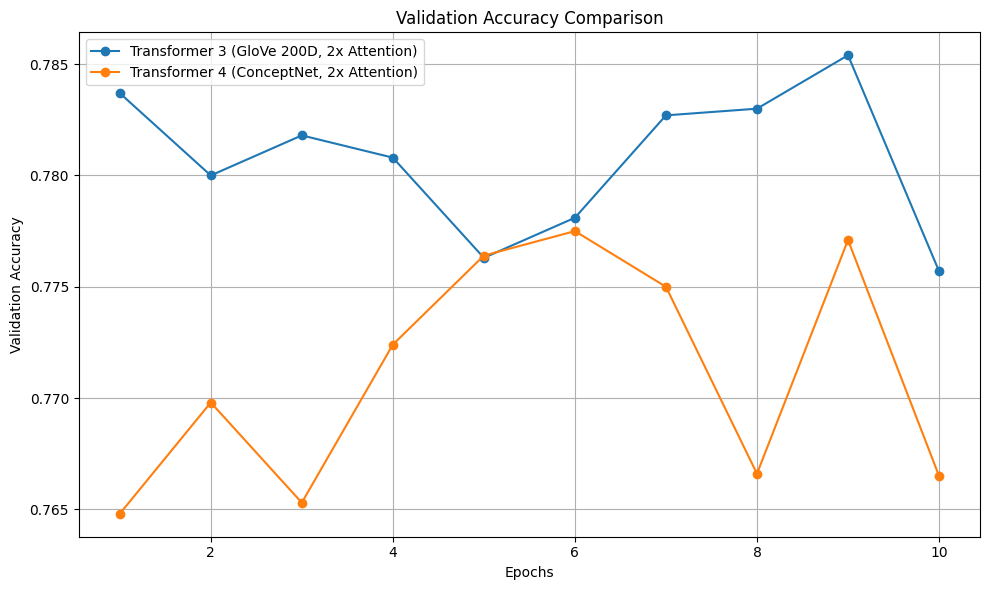

In [68]:
model_histories = [history_xformer3[0], history_xformer_conceptnet[0]]
model_names = ['Transformer 3 (GloVe 200D, 2x Attention)', 'Transformer 4 (ConceptNet, 2x Attention)']
plot_history(model_histories, model_names)

In [69]:
paired_t_test(history_xformer3[0], history_xformer_conceptnet[0])

Paired t-test results:
T-statistic: 4.7871541748446065
P-value: 0.0009913235203440687
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


So it seems that the ConceptNet transformer slightly underperforms Transformer 3. Sometimes the accuracies are extremely close, but for the most part transformer 3 is above the ConceptNet transformer by 1-2 percentage points. There is indeed a statistical difference between the two models, which makes sense. Although the architectures are the same, having an entirely different embedding source should result in different relationships in between the words, and therefore different predictions. So GloVe is better for our specific application. This isn't to say that ConceptNet is not useful - even without being a Twitter-oriented word embedding set, like how our GloVe embeddings were, a model trained on ConceptNet was still able to reach just about the same performance as our best model. Ultimately though, we would stick with the GloVe Twitter embeddings, because those are more closely oriented to our specific application of Twitter sentiment analysis.